In [1]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local
!rm Miniconda3-latest-Linux-x86_64.sh
!conda install tensorflow==2.0.0 keras matplotlib pandas tqdm scipy

--2021-12-01 06:41:30--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66709754 (64M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  63.62M   151MB/s    in 0.4s    

2021-12-01 06:41:30 (151 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [66709754/66709754]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py39h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py39h06a4308_0
    - cffi==1.14.6=py39h400218f_0
    - chardet==4.0.0=py3

In [2]:
!conda install opencv

Solving environment: - \ | / - \ | / - \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \

In [3]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [4]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model


In [5]:
! pip install kaggle

     |████████████████████████████████| 58 kB 2.6 MB/s 
     |████████████████████████████████| 247 kB 10.8 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=f45f8c65a3aed408800e0d4d7b73469997d08fde7d976a48bb195af787de94dd
  Stored in directory: /root/.cache/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download xhlulu/140k-real-and-fake-faces

100% 3.74G/3.75G [01:04<00:00, 32.8MB/s]
100% 3.75G/3.75G [01:04<00:00, 62.8MB/s]


In [10]:
! unzip 140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [11]:
base_path = 'real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)


Found 100000 images belonging to 2 classes.


In [12]:
image_gen1 = ImageDataGenerator(rescale=1./255.)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [13]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(densenet)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [14]:
train_steps = 100000//64
valid_steps = 20000//64

history = model.fit_generator(
    train_flow,
    epochs = 7,
    steps_per_epoch =train_steps,
    validation_data =valid_flow,
    validation_steps = valid_steps
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/7
1562/1562 [==============================] - 2208s 1s/step - loss: 0.5455 - accuracy: 0.7134 - val_loss: 0.4634 - val_accuracy: 0.7794
Epoch 2/7
1562/1562 [==============================] - 2177s 1s/step - loss: 0.2922 - accuracy: 0.8762 - val_loss: 0.6335 - val_accuracy: 0.7209
Epoch 3/7
1562/1562 [==============================] - 2177s 1s/step - loss: 0.1690 - accuracy: 0.9325 - val_loss: 0.3844 - val_accuracy: 0.8411
Epoch 4/7
1562/1562 [==============================] - 2177s 1s/step - loss: 0.1075 - accuracy: 0.9590 - val_loss: 0.2177 - val_accuracy: 0.9152
Epoch 5/7
1562/1562 [==============================] - 2177s 1s/step - loss: 0.0726 - accuracy: 0.9724 - val_loss: 0.1549 - val_accuracy: 0.9444
Epoch 6/7
1562/1562 [==============================] - 2169s 1s/step - loss: 0.0538 - accuracy: 0.9797 - val_loss: 0.1070 - val_accuracy: 0.9565
Epoch 7/7
1562/1562 [==============================] - 2173s 1s/step - loss: 0.0436 - accuracy: 0.9840 - val_loss: 0.2040 - val_ac

In [15]:
model.save('completed_trained_model.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! zip 

In [16]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()



In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

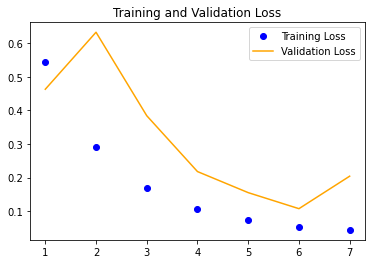

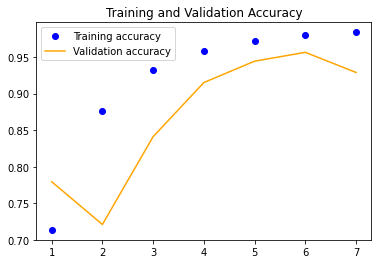

In [18]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)


In [19]:
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle = False,
    class_mode='binary'
)
y_pred = model.predict(test_flow)
y_test = test_flow.classes


Found 20000 images belonging to 2 classes.


In [20]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.9950973699999999
AP Score: 0.994833522144188

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     10000
           1       0.99      0.87      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.94      0.93      0.93     20000
weighted avg       0.94      0.93      0.93     20000

